In [1]:
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import scipy.stats as stats
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
import time

In [2]:
songs_df = pd.read_csv('results_from_800.csv').drop(['Unnamed: 0'],axis=1)
songs_df.head()

,mood,lyrics,id,prediction,valence,arousal,relyOnLinear
0,angry,"['[Chorus]', 'Catch me on your block', ""Always...",1SSv8SA2OHfOUwLgb8yOum,angry,-0.000569,0.011378,True
1,angry,"['[INTRO]', 'YEAHHHHHH', 'IMMA NEED YALL TO TU...",7CMy59461Q3pgsPZ4Cj8CP,angry,-0.792216,0.597704,False
2,angry,"[""I'm about to grab my 44, I pop the trunk so ...",5FX30idriKlEIRYTxpNf65,top ratings all neutral,0.000000,0.000000,True
3,angry,"['[Intro]', 'Thraxx', '[Chorus: ZillaKami]', ""...",2muf1caAmZ5AqPUFeIaP9r,angry,-0.768990,0.577953,False
4,angry,"['[Intro]', 'Ayy, ayy, ayy, ayy, ayy, ayy, ayy...",4Zdp7FjQOG1ejeV06dUiv6,angry,-0.239124,0.379639,False


In [3]:
#Setup Spotify and Firebase Credentials
sp = None
def spotify_client():
    global sp
    sp_cred = None
    with open('spotify_credentials.json') as credentials:
        sp_cred = json.load(credentials)
    sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(sp_cred["client_id"],sp_cred['client_secret']))
    
LR_model = None
def load_LR_model():
    global LR_model
    with open('logreg_model1.pkl','rb') as f:
        LR_model = pickle.load(f)
    warnings.filterwarnings("ignore", message="X does not have valid feature names, but LogisticRegression was fitted with feature names")
    
RF_model = None
def load_RF_model():
    global RF_model
    with open('rf2.pkl','rb') as f:
        RF_model = pickle.load(f)
        
MLP_model = None
def load_mlp_model():
    global MLP_model
    with open('MLP2.pkl','rb') as f:
        MLP_model = pickle.load(f)
    

In [4]:
#First, we need to obtain the centroids for each model:

#Create dict of dict of labels for each model
predicted_labels = {"MLP":{},"LR":{},"RF":{}, "CS":{}}


moods = ['sad','angry','energetic','excited','happy','content','calm','depressed'] #Represents DB indexing of moods
#Centroid features for the MLP, RF, and LR Models
centroid_features_MLP_RF = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                            'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 
                            'duration_ms', 'time_signature']
centroid_features_LR_CS = ['valence', 'energy']

#--------------------
# Classify Songs 
#--------------------

#Predicting labels of songs for each model
def assignLabels(names, song_ids):
    global sp
    if sp == None:
        spotify_client()
    
    predictions = {}
    predictions_prob = {}
    track_data = {}
    for name in names:
        predictions[name] = {}
        predictions_prob[name] = {}
        track_data[name] = {}
        # Use Spotipy to retrieve track information
        features_df = retrieveTrackFeatures(name, song_ids)
        processed_features_df = clipAndNormalize(name, features_df)
        if processed_features_df.shape[0] == 0:
            return {"error": "Issue with model and/or spotify server"}
        else:
            for key, row in processed_features_df.iterrows():
                data = row.values.reshape(1,-1)
                pred, pred_probability = getMoodLabel(name, data)
                predictions[name][key]=pred[0]
                predictions_prob[name][key]=list(pred_probability[0])
                track_data[name][key]=list(data[0])
    return (predictions, predictions_prob, track_data)

#--------------------
# Calculate Centroids
#--------------------

#Assign centroids for each model
def assignCentroids(names, predicted_labels, track_data):    
    model_centroids = {}
    for name in names:
        centroids = {mood:{} for mood in moods}
        predictions_current_model = predicted_labels[name]
        data = track_data[name]
        for mood_index in range(len(moods)):
            mood_song_scores = {song_id:data[song_id] for song_id, value in predictions_current_model.items() 
                                if value == mood_index}
            mood = moods[mood_index]
            fields = centroid_features_LR_CS if name in ['LR','CS'] else centroid_features_MLP_RF
            centroid = calculateCentroid(mood_song_scores, fields)
            if centroid is not None:
                centroids[mood] = centroid 
            #else default value for centroid??? (currently just 0.0)
        model_centroids[name] = centroids
    return model_centroids

#Calculate a single centroid
def calculateCentroid(songs, fields): #assuming songs is stored as {id: scores}
    num_songs = len(songs)
    if num_songs == 0: return None
    #get scores for the mood
    num_fields = len(fields)
    weight = 1/num_songs
    cumulative_score = [0 for element in range(num_fields)]
    for scores in songs.values():
        cumulative_score = np.add(scores, cumulative_score)
    final_scores = np.multiply(weight, cumulative_score)
    centroid = {feature:value for feature,value in zip(fields, final_scores)}
    return centroid


#--------------------
# Retrieve Closest Songs to Centroid
#--------------------
#Return closest songs for all moods for each model
def closestSongs(names, track_data, predictions, model_centroids):
    model_closest_songs = {}
    for name in names:
        model_closest_songs[name] = {}
        for mood_index in range(len(moods)):
            mood = moods[mood_index]
            centroid = model_centroids[name][mood]
            centroid_list = list(centroid.values())
            mood_songs = [track for track in predictions[name] if predictions[name][track] == mood_index] 
            songs = {track:track_data[name][track] for track in mood_songs}
            distances = []
            for (song_name, score) in songs.items():
                calculated_distance = cosineSimilarity(centroid_list, score)
                distances.append((song_name,calculated_distance))
            #sort the distances by value
            distances = sorted(distances, key=lambda x: x[1], reverse=True)
            #return the song names in order of closest to the centroid
            closest_songs = [pair[0] for pair in distances]
            model_closest_songs[name][mood] = closest_songs
    return model_closest_songs


#--------------------
# Generate Playlist 
#--------------------

def generateNewSongsList(names, num_songs, model_closest_songs): 
    global sp
    if sp == None:
        spotify_client()
    
    predicted_labels = {}
    final_stats = {}
    for name in names:
        predicted_labels[name] = {}
        final_stats[name] = {}
        for mood in moods:
            start_time = time.time()
            stats = {}
            predicted_labels[name][mood] = {}
            mood_index = moods.index(mood) #Numbered label of mood
            #specify target and close moods
#             acceptable_moods = [mood_index, (mood_index + len(moods) - 1) % len(moods), (mood_index + 1)%len(moods)]
            acceptable_moods = [mood_index]
            song_count = 0
            count_mood_index = 0 #TESTING TO DETERMINE RATE OF SONG ADDITION
            count_other_moods = 0
            count_similar_moods = 0
            counts = {}
            
            closest_song_ids = model_closest_songs[name][mood][:5]
            # Use Spotipy to retrieve track information
            track_info = sp.tracks(closest_song_ids)['tracks']
            # Remove any elements that are None
            track_info = [track for track in track_info if track is not None]
            if len(track_info) == 0:
                return {"error": "could not identify any tracks in the closest songs list"}
            # Extract the URIs from the track information
            track_uris = [track['uri'] for track in track_info]
            final_song_ids = []
            while len(final_song_ids) < num_songs:        
                # Get recommended tracks and add them to final_song_ids if mood is classified as specified mood
                tracks = sp.recommendations(seed_tracks=track_uris[:5], limit=100)['tracks'] ##############################LIMIT
                track_ids = [track["id"] for track in tracks if track["id"] not in final_song_ids]
                # Get song features of the new ids
                features_df = retrieveTrackFeatures(name, track_ids)
                # Preprocess features
                processed_features_df = clipAndNormalize(name, features_df)

                # If there are no features or lyrics, and no songs are already labelled return an error
                if processed_features_df.shape[0] == 0:
                    return {"error": "Issue with model and/or spotify server"}
                else:
                    stop_loops = False
                    
                    for key, row in processed_features_df.iterrows():
                        if not(stop_loops):
                            data = row.values.reshape(1,-1)
                            pred, pred_probability = getMoodLabel(name, data)
                            predicted_labels[name][mood][key]=pred[0]
                            if pred in acceptable_moods: song_count += 1
                            stop_loops = (song_count == num_songs)

                    # Combine predictions and known labels
                    # Currently, this will prioritize adding new songs to playlist over hits in our DB
                    num_songs_remaining = num_songs - song_count
                    
                # Add the remaining (newly predicted) song IDs where mood = mood_index
                ids_to_add = [key for key in predicted_labels[name][mood].keys() if predicted_labels[name][mood][key] in acceptable_moods]
                final_song_ids.extend(ids_to_add)
                
            ### TESTING TO DETERMINE RATE OF SONG ADDITION
            ###STAT DICT FOR TESTING
            end_time = time.time()
            elapsed_time = end_time - start_time
            stat_dict = predicted_labels[name][mood]
            count_mood_index += len([key for key in stat_dict.keys() if stat_dict[key] == mood_index])
            count_other_moods += len(stat_dict) - len(final_song_ids)
            count_similar_moods += len([key for key in stat_dict.keys() if stat_dict[key] in 
                                        [(mood_index + len(moods) - 1) % len(moods), 
                                         (mood_index + 1)%len(moods)]])
            print(f"{name}:{mood}")
            print(f"\tcount of specified moods: {count_mood_index}")
            print(f"\tcount of other moods: {count_other_moods}")
            print(f"\tcount of similar moods: {count_similar_moods}")

            unique_elements = range(8)
            for elem in unique_elements:
                count = list(stat_dict.values()).count(elem)
                counts[moods[elem]] = counts.get(elem,0) + count
            print(f"\tcount of labels: {counts}")
            print(f"\tcounts: {counts.values()}")
            count_prob = {k: v/sum(counts.values()) for k,v in counts.items()}
            print(f"\tprobability of labels: {count_prob}")
            print(f"\telapsed time: {elapsed_time}")
            stats["count_mood_index"] = count_mood_index
            stats["count_other_moods"] = count_other_moods
            stats["count_similar_moods"] = count_similar_moods
            stats["label_counts"] = counts
            stats["label_prob"] = count_prob
            stats["elapsed_time"] = elapsed_time
            final_stats[name][mood] = stats
        
    return (predicted_labels, final_stats)

In [5]:
#--------------------
# Dispatcher Methods
#--------------------
def getMoodLabel(name, features):
    if name == "MLP":
        return getMoodLabelMLP(features)
    elif name == "RF":
        return getMoodLabelRF(features)
    elif name == "CS":
        return getMoodLabelCS(features)
    else: 
        return getMoodLabelLR(features)
    
def clipAndNormalize(name, features):
    if name == "MLP":
        return clipAndNormalizeMLP(features)
    elif name == "RF":
        return clipAndNormalizeRF(features)
    elif name == "CS":
        return clipAndNormalizeCS(features)
    else: 
        return features #Nothing needed for LR model

def retrieveTrackFeatures(name, track_ids):
    dfs = []
    for i in range(0, len(track_ids), 50):
        # Retrieve track features with current offset
        features = sp.audio_features(track_ids[i:i+50])
        checked_features = [l for l in features if l is not None]
        # Convert to DataFrame
        if len(checked_features) > 0:
            df = pd.DataFrame(checked_features)

            # Remove columns that we don't need
            if name in ['LR','CS']:
                df = df[['id', 'valence', 'energy']]
            else:
                df = df.drop(['type', 'uri', 'analysis_url', 'track_href'], axis=1)

            # Append to list of dataframes
            dfs.append(df)
    
    # Concatenate all dataframes into a single one
    features_df = pd.concat(dfs, ignore_index=True)
    features_df.set_index("id", inplace=True)
    #convert to dictionary, with track id as key
#     features_dict = features_df.set_index('id').T.to_dict('list')
    return features_df
    
#--------------------
# MLP Functions
#--------------------
def getMoodLabelMLP(songFeatures):
    if MLP_model is None:
        load_mlp_model()
    prediction = MLP_model.predict(songFeatures)
    pred_probability= MLP_model.predict_proba(songFeatures)
    return prediction, pred_probability

def clipAndNormalizeMLP(features):
    #clip the features to the range of the training data
    features['danceability'] = features['danceability'].clip(lower=0.22718080000000002, upper=0.906)
    features['energy'] = features['energy'].clip(lower=0.03545904, upper=0.978)
    features['loudness'] = features['loudness'].clip(lower=-26.4981552, upper=-1.6015904000000007)
    features['speechiness'] = features['speechiness'].clip(lower=0.0257, upper=0.46640959999999926)
    features['acousticness'] = features['acousticness'].clip(lower=8.353136000000001e-05, upper=0.9884095999999992)
    features['instrumentalness'] = features['instrumentalness'].clip(lower=0.0, upper=0.956)
    features['liveness'] = features['liveness'].clip(lower=0.0494, upper=0.697)
    features['valence'] = features['valence'].clip(lower=0.0382, upper=0.923)
    features['tempo'] = features['tempo'].clip(lower=63.7631808, upper=188.00344319999996)
    features['duration_ms'] = features['duration_ms'].clip(lower=88264.8768, upper=372339.1727999991)
    features['time_signature'] = features['time_signature'].clip(lower=3.0, upper=5.0)

    #normalize the data
    scaler = pickle.load(open('scaler2.pkl', 'rb'))
    preprocessedFeatures = scaler.transform(features)

    #convert to dictionary, with track id as key
    preprocessedFeatures = pd.DataFrame(preprocessedFeatures, columns=features.columns)
    preprocessedFeatures['id'] = features.index.to_list()
    preprocessedFeatures.set_index('id', inplace=True)

    return preprocessedFeatures

#--------------------
# RF Functions
#--------------------
def getMoodLabelRF(songFeatures):
    if RF_model is None:
        load_RF_model()
    prediction = RF_model.predict(songFeatures)
    pred_probability= RF_model.predict_proba(songFeatures)
    return prediction, pred_probability

def clipAndNormalizeRF(features):
    #clip the features to the range of the training data
    features['danceability'] = features['danceability'].clip(lower=0.25336000000000003, upper=0.9188199999999997)
    features['energy'] = features['energy'].clip(lower=0.047536, upper=0.982)
    features['loudness'] = features['loudness'].clip(lower=-24.65708, upper=-0.8038200000000288)
    features['speechiness'] = features['speechiness'].clip(lower=0.0263, upper=0.5018199999999997)
    features['acousticness'] = features['acousticness'].clip(lower=1.4072e-04, upper=0.986)
    features['instrumentalness'] = features['instrumentalness'].clip(lower=0.0, upper=0.951)
    features['liveness'] = features['liveness'].clip(lower=0.044836, upper=0.7224599999999991)
    features['valence'] = features['valence'].clip(lower=0.038318, upper=0.9348199999999998)
    features['tempo'] = features['tempo'].clip(lower=66.34576, upper=189.87784)
    features['duration_ms'] = features['duration_ms'].clip(lower=86120.0, upper=341848.79999999976)
    features['time_signature'] = features['time_signature'].clip(lower=3.0, upper=5.0)
    
    columns_to_log=['liveness', 'instrumentalness', 'acousticness', 'speechiness','loudness','energy']

    for i in columns_to_log:
        if i == 'loudness':
            features[i] = features[i] + 60
        features[i] = np.log(features[i]+1)

    #normalize the data
    scaler = pickle.load(open('scaler3.pkl', 'rb'))
    #fit on all columns except the track id
    preprocessedFeatures = scaler.transform(features)

    #convert to dictionary, with track id as key
    preprocessedFeatures = pd.DataFrame(preprocessedFeatures, columns=features.columns)

    
    #apply z-score normalization
    for i in columns_to_log:
        preprocessedFeatures[i] = stats.zscore(preprocessedFeatures[i])
        preprocessedFeatures.clip(lower=-2.7, upper=2.7, inplace=True)

    preprocessedFeatures['id'] = features.index.to_list()
    preprocessedFeatures.set_index('id', inplace=True)

#     preprocessedFeatures = preprocessedFeatures.set_index('id').T.to_dict('list')
    return preprocessedFeatures


#--------------------
# LR Functions
#--------------------

def getMoodLabelLR(songFeatures):
    if LR_model is None:
        load_LR_model()
    prediction = LR_model.predict(songFeatures)
    pred_probability= LR_model.predict_proba(songFeatures)
    return prediction, pred_probability

#--------------------
# Centroid Similarity Functions
#--------------------
valenceArousalToLabel = [
  # Low, Medium, High Arousal
  ["depressed", "sad", "angry"],    # Low Valence
  ["calm", "neutral", "energetic"], # Medium Valence
  ["content", "happy", "excited"],  # High Valence
]
# Get size label of valence and arousal
def getMoodLabelCS(songFeatures):
    valence = songFeatures[0][0]
    arousal = songFeatures[0][1]
    (valence_label, arousal_label) = getValenceArousalLabels(valence, arousal)
    mood = valenceArousalToLabel[valence_label][arousal_label];
    pred = [moods.index(mood)] # other functions return as array
    return pred, [[]]

# Helper for getMoodLabelCS
def getValenceArousalLabels(valence, arousal):
    LOW = 0
    MEDIUM = 1
    HIGH = 2
    to_labeled_size = lambda val: HIGH if val >= 0.5 else LOW if val <= -0.5 else MEDIUM
    valence_label = to_labeled_size(valence)
    arousal_label = to_labeled_size(arousal)
    if valence_label == MEDIUM and arousal_label == MEDIUM:
        # Case where both are medium
        valence_label = HIGH if valence > 0.25 else LOW if valence < -0.25 else MEDIUM
        arousal_label = HIGH if arousal > 0.25 else LOW if arousal < -0.25 else MEDIUM
        # Check if they are both still medium
        if valence_label == MEDIUM and arousal_label == MEDIUM:
            valence_is_bigger_extreme = abs(valence) <= abs(arousal)
            valence_label = LOW if valence < 0 and valence_is_bigger_extreme else HIGH if valence_is_bigger_extreme else valence_label
            arousal_label = LOW if arousal < 0 and not valence_is_bigger_extreme else HIGH if not valence_is_bigger_extreme else arousal_label
    return valence_label, arousal_label

def clipAndNormalizeCS(features):
    # define the midpoint and range of the new scale
    midpoint = 0.5
    scale_range = 1
    # adjust for bias
    valence_bias = 0.5 - sum(features['valence'])/len(features)
    energy_bias = 0.5 - sum(features['energy'])/len(features)
    # rescale the "valence" column to the new scale
    features['valence'] = (features['valence'] + valence_bias - midpoint) * (2 * scale_range)
    # rescale the "energy" column to the new scale
    features['energy'] = ((features['energy'] + energy_bias - midpoint) * (2 * scale_range))
    # clip the values in the to the range of -1 to 1
    features['valence'] = features['valence'].clip(lower=-1.0, upper=1.0)
    # clip the values in the "energy" column to the range of -1 to 1
    features['energy'] = features['energy'].clip(lower=-1.0, upper=1.0)
    
    return features

#--------------------
# Retrieve Closest Songs Functions
#--------------------

def cosineSimilarity(arr1, arr2):
    return np.dot(arr1, arr2)/(norm(arr1)*norm(arr2))

In [6]:
id_list = songs_df["id"].to_list()
names = ['CS', 'MLP', 'LR', 'RF']

In [7]:
(predictions, predictions_prob, track_data) = assignLabels(names, id_list)

In [8]:
#If the kernel crashes, recover here
print(predictions)
print("\n")
print(predictions_prob)
print("\n")
print(track_data)

{'CS': {'1SSv8SA2OHfOUwLgb8yOum': 4, '7CMy59461Q3pgsPZ4Cj8CP': 2, '5FX30idriKlEIRYTxpNf65': 3, '2muf1caAmZ5AqPUFeIaP9r': 2, '4Zdp7FjQOG1ejeV06dUiv6': 0, '2Eb5AK8EUN8oz5nlzSr4b7': 1, '6nfnDSD5Wa9LAD8jeN5tix': 2, '0OEElGULHOyTpEGPkwS6qv': 0, '4evnuNKgYSrq1UFc9uK8Wp': 0, '1sEl1ouRDpdeLnzK9KSBAH': 2, '0Sd0kdgU6HrIclxYjuV99j': 4, '2UEXRIn2kKNQ89cLTGElhI': 2, '4Z4j7hNfhy8d8RgQmIBFtY': 2, '7HPY5EAOs3ryjWEDYsVakZ': 2, '5UShsJdqJLZkl5JNj1ITlP': 2, '49fsYdg1kdM5FDwyuUAtSx': 5, '53BQoobXsTQAwv4TwbxAgw': 0, '1cwcmyyPTjJrH2tZpjrYxD': 0, '6qzQtWbD2XEsOQcK0zu0q8': 0, '0Sgk9iiFGgjVxJfXv2L3iF': 4, '6zBqlhWjEhNyH4Z8eUDzMT': 3, '77NhhvFASZAEccPdDSDIgg': 0, '1YaPhbIo2oKWT5ejlMEL5Z': 4, '6R0GRYk2vs2XuBVemYK5YZ': 4, '0I61n7IBIaadheTiaOcg0s': 2, '5hn8iHKjGPmex6P9nhvWiS': 2, '4uUUPTF8566PHM1dZqH5Kb': 2, '0NFCrBf6tnaDTZ5xOWjHCI': 4, '2XXFajkaWMZ2ukPNPKgLWa': 3, '2UJVLvdnmUOkIvVkSaC2pj': 0, '48TYKdjkiIN6brcIilEVWB': 2, '6I90hMc9paVMjNPxMOXoot': 0, '6moq1tqcuva009QzFoNW5V': 3, '7gForEsm1KqmsIy8Hfxi6v': 4, '13M03

In [9]:
model_centroids = assignCentroids(names, predictions, track_data)
model_centroids

{'CS': {'sad': {'valence': -0.4152793002915445,
   'energy': -0.06320026196814181},
  'angry': {'valence': -0.5134935860058302, 'energy': 0.4946548104956263},
  'energetic': {'valence': 0.019088815650484443, 'energy': 0.3811475641188147},
  'excited': {'valence': 0.5218970315398894, 'energy': 0.4819275377683537},
  'happy': {'valence': 0.5754920416042871, 'energy': 0.12303318887400465},
  'content': {'valence': 0.38692069970845544, 'energy': -0.45094518950437373},
  'calm': {'valence': -0.11829220351735095, 'energy': -0.48147364807674264},
  'depressed': {'valence': -0.5064007288629729,
   'energy': -0.5756542898792175}},
 'MLP': {'sad': {'danceability': 0.0821646491031311,
   'energy': 0.17502586432242062,
   'key': -0.19284124722835375,
   'loudness': 0.5017136062311528,
   'mode': 0.16229266297829256,
   'speechiness': -0.1278125446984899,
   'acousticness': -0.03666203911329251,
   'instrumentalness': -0.5536689057165527,
   'liveness': 0.13264112371250555,
   'valence': 0.51373137

In [10]:
model_closest_songs = closestSongs(names, track_data, predictions, model_centroids)
model_closest_songs

{'CS': {'sad': ['2OrMrZo3yQ2zJHOttgZ992',
   '0alSPoUfrGb0RdVVG4Lf3n',
   '4Zdp7FjQOG1ejeV06dUiv6',
   '5YSHygGN9D0mID1NsVd5my',
   '5TWDEpnXNbkigqoxg1cX4J',
   '49QVOdWgGagzLrThkIqtK6',
   '4IsRf4laCzdHD9JEp9LTSk',
   '5pesNiBKAx8JNwK2mQ2HEc',
   '2FkbeqpCrjjDdVH1SZgDo6',
   '6qzQtWbD2XEsOQcK0zu0q8',
   '4CCrZzRdeWYrWJ0DoN4XCa',
   '2ksyzVfU0WJoBpu8otr4pz',
   '2izlCxatn0nR7SyRyrkUW1',
   '0OEElGULHOyTpEGPkwS6qv',
   '6kckNpuM5oXZrObLExRg6d',
   '1cwcmyyPTjJrH2tZpjrYxD',
   '4vC2iSW6pMcDvAb98Tc8ma',
   '1qMMYpVatbRITKCfq1gasi',
   '2NM0qHzx4Ohy8iXHEEgwlO',
   '4eL3XeuGaEoVT8ttDh3hwY',
   '3sgf2a905hjZ81tXYytY6i',
   '4nVBt6MZDDP6tRVdQTgxJg',
   '20aikfEJe45GRQntkDKXkY',
   '3NLrRZoMF0Lx6zTlYqeIo4',
   '5covx4W77ZCuXI0ejgoZh0',
   '2aDdioTmKP1yUWgmzBbi70',
   '7865MYTYATLVWUUApjAzSW',
   '0dYpPDvC5XA0E7LcrvGWOA',
   '79EkGysjP2dL5GdpeQjRxT',
   '1HLL8X0LH20F6Z9SLXLIjr',
   '2Qt8qG9SWPdtRiaWcPNJRm',
   '6NFyWDv5CjfwuzoCkw47Xf',
   '0i7KR2K55SumDlbtsvxwKz',
   '7eX3um6NpOQKWJMGCi97XD',
 

In [52]:
num_songs = 200
model_predicted_labels, model_stats = generateNewSongsList(names, num_songs, model_closest_songs)

CS:sad
	count of specified moods: 105
	count of other moods: 23
	count of similar moods: 31
	count of labels: {'sad': 105, 'angry': 11, 'energetic': 32, 'excited': 11, 'happy': 81, 'content': 2, 'calm': 42, 'depressed': 20}
	counts: dict_values([105, 11, 32, 11, 81, 2, 42, 20])
	probability of labels: {'sad': 0.34539473684210525, 'angry': 0.03618421052631579, 'energetic': 0.10526315789473684, 'excited': 0.03618421052631579, 'happy': 0.26644736842105265, 'content': 0.006578947368421052, 'calm': 0.13815789473684212, 'depressed': 0.06578947368421052}
	elapsed time: 3.5203750133514404
CS:angry
	count of specified moods: 34
	count of other moods: 226
	count of similar moods: 180
	count of labels: {'sad': 129, 'angry': 34, 'energetic': 51, 'excited': 8, 'happy': 128, 'content': 13, 'calm': 61, 'depressed': 11}
	counts: dict_values([129, 34, 51, 8, 128, 13, 61, 11])
	probability of labels: {'sad': 0.296551724137931, 'angry': 0.07816091954022988, 'energetic': 0.11724137931034483, 'excited': 0.

MLP:calm
	count of specified moods: 101
	count of other moods: 1
	count of similar moods: 162
	count of labels: {'sad': 13, 'angry': 0, 'energetic': 2, 'excited': 1, 'happy': 0, 'content': 22, 'calm': 101, 'depressed': 140}
	counts: dict_values([13, 0, 2, 1, 0, 22, 101, 140])
	probability of labels: {'sad': 0.04659498207885305, 'angry': 0.0, 'energetic': 0.007168458781362007, 'excited': 0.0035842293906810036, 'happy': 0.0, 'content': 0.07885304659498207, 'calm': 0.36200716845878134, 'depressed': 0.5017921146953405}
	elapsed time: 3.336717128753662
MLP:depressed
	count of specified moods: 123
	count of other moods: -21
	count of similar moods: 22
	count of labels: {'sad': 21, 'angry': 17, 'energetic': 35, 'excited': 27, 'happy': 5, 'content': 10, 'calm': 1, 'depressed': 123}
	counts: dict_values([21, 17, 35, 27, 5, 10, 1, 123])
	probability of labels: {'sad': 0.08786610878661087, 'angry': 0.07112970711297072, 'energetic': 0.14644351464435146, 'excited': 0.11297071129707113, 'happy': 0.0

RF:happy
	count of specified moods: 79
	count of other moods: 52
	count of similar moods: 131
	count of labels: {'sad': 7, 'angry': 18, 'energetic': 41, 'excited': 23, 'happy': 79, 'content': 108, 'calm': 47, 'depressed': 1}
	counts: dict_values([7, 18, 41, 23, 79, 108, 47, 1])
	probability of labels: {'sad': 0.021604938271604937, 'angry': 0.05555555555555555, 'energetic': 0.12654320987654322, 'excited': 0.07098765432098765, 'happy': 0.24382716049382716, 'content': 0.3333333333333333, 'calm': 0.14506172839506173, 'depressed': 0.0030864197530864196}
	elapsed time: 108.56499099731445
RF:content
	count of specified moods: 90
	count of other moods: 34
	count of similar moods: 73
	count of labels: {'sad': 14, 'angry': 19, 'energetic': 66, 'excited': 7, 'happy': 6, 'content': 90, 'calm': 67, 'depressed': 14}
	counts: dict_values([14, 19, 66, 7, 6, 90, 67, 14])
	probability of labels: {'sad': 0.04946996466431095, 'angry': 0.06713780918727916, 'energetic': 0.2332155477031802, 'excited': 0.0247

In [53]:
model_predicted_labels

{'CS': {'sad': {'6FbFmJgyXcL3hmdGK41aSi': 4,
   '3BJcTgZiU1l2msoyi803I8': 2,
   '2r6OAV3WsYtXuXjvJ1lIDi': 2,
   '38XV6iEQsRNVEq25iVLSx1': 0,
   '4bLXPGpnMw9WMPOZv2hCD7': 1,
   '394yrCYgwPX9m9V0sqUIbN': 0,
   '0e8DgtfJnWTBarF9YGMd0N': 3,
   '670lYAoYGz4ebJlfiX9KmJ': 7,
   '4F6YLjakjqWFTgC5qfEwPQ': 6,
   '03XcroWJiXFFnBRk5wuRLQ': 4,
   '5SnQILxl7lE7J8bRgM3NSb': 4,
   '0WufBpRH9k4U6OcZuUmjhu': 0,
   '17G2eoc6sb3yqb1kJCPsgE': 2,
   '036UfY22ma3Qs80k5gafkd': 6,
   '66EOXuyTELBsRtI9wWXFxr': 7,
   '0aZnyTWJNgdzYoOiaW8HKG': 4,
   '3L19besdNQzd342qL78xqm': 0,
   '5dBP9gDiDlsXiitxvB4HGb': 0,
   '0si0BqHFccbmGENDvATw2g': 0,
   '3uVPLtkmDu8pDkYEAVqbgS': 4,
   '4FSspnJDbnbmzGDTd9ZAXr': 6,
   '3UBYhH88mEN3Xtz1BTgt9H': 4,
   '733c1CWmIGymoQXdp7Us88': 4,
   '0qHbOme0fFyIWLNie9HG2t': 2,
   '2c5LB4wbweJ73WA8t0GxY6': 2,
   '2BJWxD8xKrDv8vneTvTIm9': 2,
   '1cwcmyyPTjJrH2tZpjrYxD': 0,
   '62vDrkBEyJYEOFj1ScBqM7': 4,
   '5kkaSMcf4BFlhRRICCKZb6': 4,
   '0TGhavJ0g5OyhWGunuai4y': 5,
   '2AlYncTpVHKwHb55F9lF6O'

In [54]:
model_stats

{'CS': {'sad': {'count_mood_index': 105,
   'count_other_moods': 23,
   'count_similar_moods': 31,
   'label_counts': {'sad': 105,
    'angry': 11,
    'energetic': 32,
    'excited': 11,
    'happy': 81,
    'content': 2,
    'calm': 42,
    'depressed': 20},
   'label_prob': {'sad': 0.34539473684210525,
    'angry': 0.03618421052631579,
    'energetic': 0.10526315789473684,
    'excited': 0.03618421052631579,
    'happy': 0.26644736842105265,
    'content': 0.006578947368421052,
    'calm': 0.13815789473684212,
    'depressed': 0.06578947368421052},
   'elapsed_time': 3.5203750133514404},
  'angry': {'count_mood_index': 34,
   'count_other_moods': 226,
   'count_similar_moods': 180,
   'label_counts': {'sad': 129,
    'angry': 34,
    'energetic': 51,
    'excited': 8,
    'happy': 128,
    'content': 13,
    'calm': 61,
    'depressed': 11},
   'label_prob': {'sad': 0.296551724137931,
    'angry': 0.07816091954022988,
    'energetic': 0.11724137931034483,
    'excited': 0.0183908045

# Data Analysis

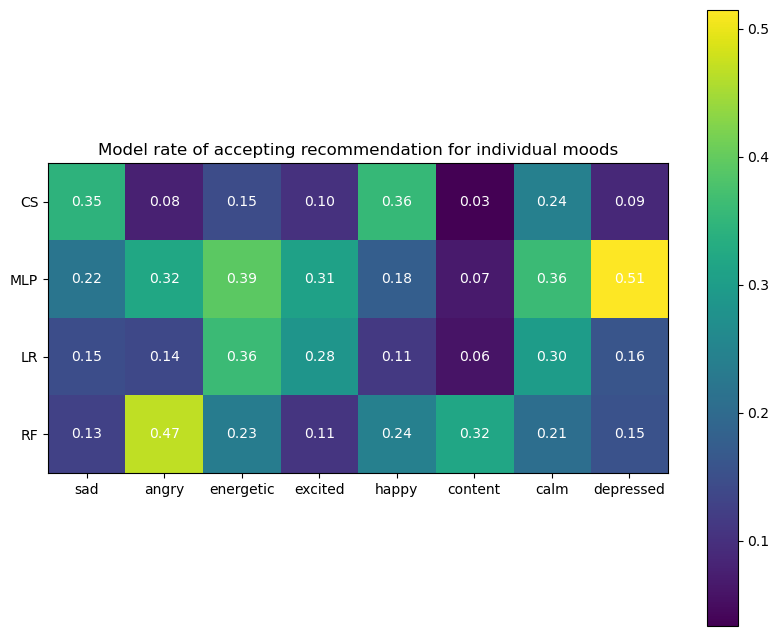

In [9]:
#Analyze acceptance rate of recommendations without similar moods
target_label_probabilities = {}
for name in names:
    target_label_probabilities[name] = {}
    for mood in moods:
        target_label_probabilities[name][mood] = model_stats[name][mood]['label_prob'][mood]

# Create a 2D array of the accuracy values
accuracy_values = np.array([[target_label_probabilities[model_name][mood_name] for mood_name in moods] for model_name in target_label_probabilities])


# Create a heatmap using matplotlib
# Create a larger figure size
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(accuracy_values, cmap='viridis')

# Add labels to the x and y axes
ax.set_xticks(np.arange(len(moods)))
ax.set_yticks(np.arange(len(target_label_probabilities)))
ax.set_xticklabels(moods)
ax.set_yticklabels(target_label_probabilities.keys())

# Add value annotations to the heatmap
for i in range(len(target_label_probabilities)):
    for j in range(len(moods)):
        text = ax.text(j, i, "{:.2f}".format(accuracy_values[i, j]), ha="center", va="center", color="w")

# Add a colorbar to the heatmap
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title of the heatmap
ax.set_title("Model rate of accepting recommendation for individual moods")

# Show the heatmap
plt.show()

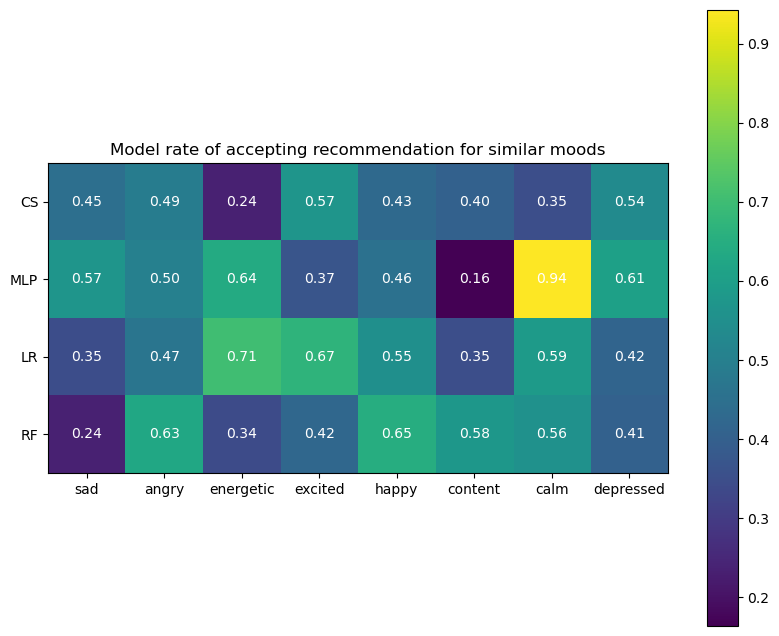

In [11]:
#Analyze acceptance rate of recommendations with similar moods
target_label_probabilities = {}
for name in names:
    target_label_probabilities[name] = {}
    for mood in moods:
        mood_index = moods.index(mood)
        mood_probs = model_stats[name][mood]['label_prob']
        target_label_probabilities[name][mood] = mood_probs[moods[mood_index]] + mood_probs[moods[mood_index - 1]] + mood_probs[moods[(mood_index + 1)%len(moods)]]

# Create a 2D array of the accuracy values
accuracy_values = np.array([[target_label_probabilities[model_name][mood_name] for mood_name in moods] for model_name in target_label_probabilities])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 8))

# Create a heatmap using matplotlib
im = ax.imshow(accuracy_values, cmap='viridis')

# Add labels to the x and y axes
ax.set_xticks(np.arange(len(moods)))
ax.set_yticks(np.arange(len(target_label_probabilities)))
ax.set_xticklabels(moods)
ax.set_yticklabels(target_label_probabilities.keys())

# Add value annotations to the heatmap
for i in range(len(target_label_probabilities)):
    for j in range(len(moods)):
        text = ax.text(j, i, "{:.2f}".format(accuracy_values[i, j]), ha="center", va="center", color="w")

# Add a colorbar to the heatmap
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title of the heatmap
ax.set_title("Model rate of accepting recommendation for similar moods")

# Show the heatmap
plt.show()

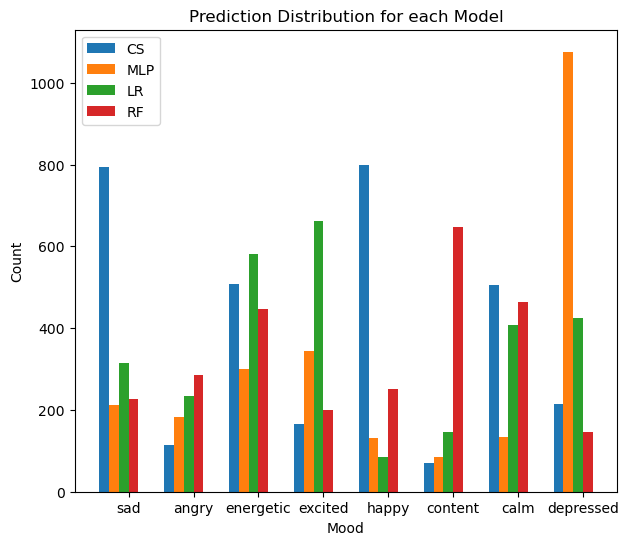

In [12]:
#Check prediction distribution of models
count_dict = {}
for name in names:
    count_dict[name] = {}
    for target_mood in moods:
        total = 0
        for predicted_mood in moods:
            total += len([v for v in model_predicted_labels[name][predicted_mood].values() if v == moods.index(target_mood)])
        count_dict[name][target_mood] = total

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(7, 6))

# Set the bar width
bar_width = 0.15

# Set the bar positions
bar_positions = [1, 2, 3, 4, 5, 6, 7, 8]

# Loop over the models and plot the bars
for i, model in enumerate(count_dict):
    # Calculate the x positions for the bars
    offset = i * bar_width
    bar_groups = [x + offset for x in bar_positions]
    
    # Get the counts for the model
    counts = [count_dict[model][mood] for mood in moods]
    
    # Plot the bars
    ax.bar(bar_groups, counts, bar_width, label=model)

# Set the x and y labels, ticks, and legend
ax.set_xlabel('Mood')
ax.set_ylabel('Count')
ax.set_xticks([x + 2.5 * bar_width for x in bar_positions])
ax.set_xticklabels(moods)
ax.legend()
ax.set_title("Prediction Distribution for each Model")

plt.show()


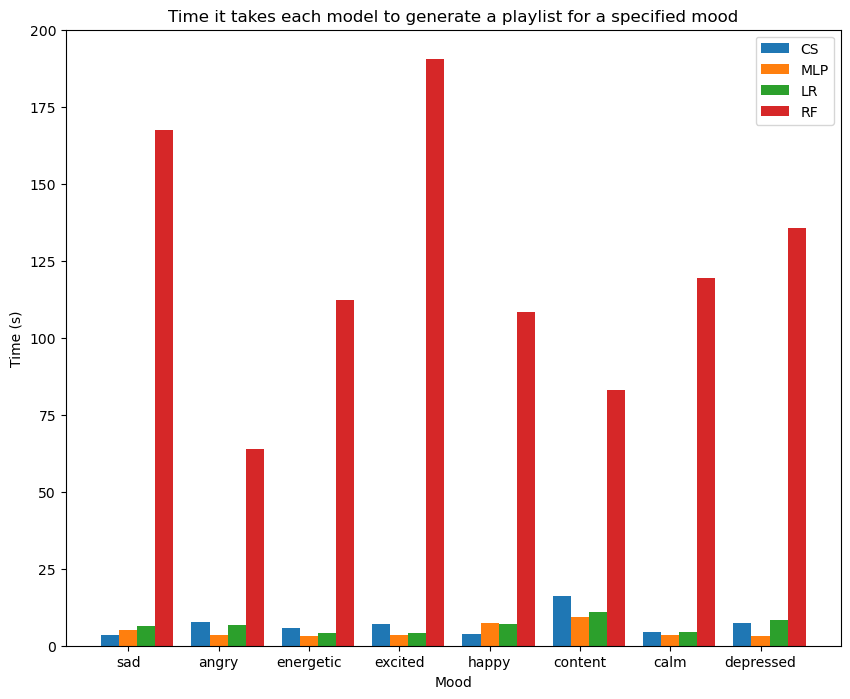

In [43]:
#Time distributions for each model
model_time_per_mood = {}
for name in names:
    model_time_per_mood[name] = {}
    for mood in moods:
        model_time_per_mood[name][mood] = model_stats[name][mood]['elapsed_time']

# Create a list of the total time taken by all models for each mood
total_times = [sum(model_time_per_mood[model][mood] for model in names) for mood in moods]

# Create a list of the time taken by each model for each mood
model_times = [[model_time_per_mood[model][mood] for model in names] for mood in moods]

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 8))

# Set the bar width
bar_width = 0.2

# Define the bar groups
bar_groups = list(model_time_per_mood[list(model_time_per_mood.keys())[0]].keys())

# Initialize the model_counts dictionary
model_counts = {model: [] for model in model_time_per_mood}

# Iterate over the models and bar groups
for model in model_time_per_mood:
    for group in bar_groups:
        # Append the time for the current model and group
        model_counts[model].append(model_time_per_mood[model][group])
    
    # Add zero-padding if necessary to make sure each model_counts[model] has the same length as bar_groups
    if len(model_counts[model]) < len(bar_groups):
        model_counts[model] += [0] * (len(bar_groups) - len(model_counts[model]))

# Set the bar positions for each model
bar_positions = []
for i, model in enumerate(model_counts):
    bar_positions += [idx + (i * bar_width) for idx in range(len(bar_groups))]

# Plot the bars
for i, model in enumerate(model_counts):
    ax.bar(bar_positions[i*len(bar_groups):(i+1)*len(bar_groups)], model_counts[model], bar_width, label=model)

# Set the x and y labels, ticks, and legend
ax.set_xlabel('Mood')
ax.set_ylabel('Time (s)')
ax.set_xticks([x + bar_width for x in range(len(bar_groups))])
ax.set_xticklabels(moods)
ax.legend()
ax.set_title('Time it takes each model to generate a playlist for a specified mood')

# Show the plot
plt.show()